In [1]:
import numpy as np 
import pandas as pd

from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from xgboost import XGBClassifier
#import lightgbm as lgb
#import tensorflow as tf
#from keras.models import Sequential
#from keras.layers import Dense

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report

import shap
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import warnings
warnings.filterwarnings('ignore')

# Data preprocessing & feature generation

In [2]:
data = pd.read_parquet('/kaggle/input/burger-king-churn/train_dataset_hackaton2023_train.gzip')
display(data.sample(5))

,customer_id,date_diff_post,buy_post,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
5445881,9475784,25.0,1,train,179.99,2023-01-09 11:56:05,Наггетсы (9 шт.),302.0,Отдельно стоящий
18117818,27926569,1.0,1,train,69.99,2023-02-01 17:26:43,Кинг Фри мал,368.6,Отдельно стоящий без внешней зоны
3674308,6836189,22.0,1,train,49.99,2023-01-26 19:40:44,Соус 1000 островов,269.9,Отдельно стоящий
23662814,41677461,4.0,1,train,69.98,2023-02-16 18:42:44,Up Сандэй Клубничный,538.7,Отдельно стоящий с внешней зоной
5090984,8706715,17.0,1,train,54.00,2023-04-13 11:59:48,Кинг Попкорн Солёненький,102.7,Фудкорт с туалетом


In [3]:
has_toilet_statuses = [
    "Отдельно стоящий с внешней зоной",
    "Отдельно стоящий без внешней зоны",
    "Отдельно стоящий",
    "Фудкорт с туалетом",
    "Отдельно стоящий с внешн.зоной без туалета",
]

hasnt_toilet_statuses = [
    "Фудкорт без туалета",
    "Отдельно стоящий без внешней зоны без туалета",
    "Отдельно стоящий без туалета",
]

with_external_zone = [
    "Отдельно стоящий с внешней зоной",
    "Отдельно стоящий с внешн.зоной без туалета",
]

without_external_zone = [
    "Отдельно стоящий без внешней зоны",
    "Отдельно стоящий без внешней зоны без туалета",
]

is_foodcourt = [
    "Фудкорт с туалетом",
    "Фудкорт без туалета",
]

proxy_features = [
    'orders_count',
    'monthly_orders_count',
    'last_month_orders_count',
    'dishes_count',
    'ownareaall_sqm'
]

revenue_proxy_features = [
    'revenue',
    'monthly_revenue',
    'last_month_revenue',
]

In [4]:
def preprocess(data, is_train=True):
    
    if is_train:
        data = data[data.format_name != 'Не заполнено']
        #slight date_diff_post aligning
        data.date_diff_post.fillna(-1, inplace=True)
        data.date_diff_post = data.date_diff_post.astype(int)
    
    # make has_toilet column and store there true or false based on has_toilet_statuses
    data['has_toilet'] = data.format_name.isin(has_toilet_statuses)

    # if has external zone then store 2, else 1, if not in with/without_external_zone then store 0
    data['has_external_zone'] = data.format_name.apply(
        lambda x: 2 if x in with_external_zone else 1 if x in without_external_zone else 0
    )

    # 2 - has external zone
    # 1 - hasnt external zone
    # 0 - not defined

    data['is_foodcourt'] = data.format_name.isin(is_foodcourt)

    data.drop('format_name', axis=1, inplace=True)
    
    if is_train:
        # filter outliers in dish_name that have less than 10000 rows
        dish_name_counts = data.dish_name.value_counts()
        dish_name_counts = dish_name_counts[dish_name_counts > 50000]
        data = data[data.dish_name.isin(dish_name_counts.index)]
    
    # create bill_id based on startdatetime and customer_id
    data['bill_id'] = data.groupby(['startdatetime', 'customer_id']).ngroup()
    
    # drop group_name
    data.drop('group_name', axis=1, inplace=True)
    
    # label encode dish_name
    le = LabelEncoder()
    data['dish_name'] = le.fit_transform(data.dish_name)
    
    if is_train:
        data = data.groupby('bill_id').agg({
            'bill_id': 'first',
            'customer_id': 'first',
            'dish_name': list,
            'startdatetime': 'first',
            'has_toilet': 'first',
            'has_external_zone': 'first',
            'is_foodcourt': 'first',
            'date_diff_post': 'first',
            'buy_post': 'first',
            'revenue': 'sum',
            'ownareaall_sqm': 'first',
        }).reset_index(drop=True)
    else:
        data = data.groupby('bill_id').agg({
            'bill_id': 'first',
            'customer_id': 'first',
            'dish_name': list,
            'startdatetime': 'first',
            'has_toilet': 'first',
            'has_external_zone': 'first',
            'is_foodcourt': 'first',
            'revenue': 'sum',
            'ownareaall_sqm': 'first',
        }).reset_index(drop=True)
    
    data['dish_amount'] = [len(n) for n in data['dish_name']]
    
    #generating even more features!
    # group data by customer_id
    data['dishes_count'] = data.dish_name.apply(lambda x: len(x))
    data['orders_count'] = data.groupby('customer_id')['bill_id'].transform('nunique')

    # count amount of orders for every month
    data['monthly_orders_count'] = data.groupby(['customer_id', data.startdatetime.dt.month])['bill_id'].transform('nunique')
    data['monthly_revenue'] = data.groupby(['customer_id', data.startdatetime.dt.month])['revenue'].transform('sum')

    # get last month
    last_month = data.startdatetime.dt.month.max()
    # get last month orders count
    data['last_month_orders_count'] = data[data.startdatetime.dt.month == last_month].groupby('customer_id')['bill_id'].transform('nunique')
    # get last month revenue
    data['last_month_revenue'] = data[data.startdatetime.dt.month == last_month].groupby('customer_id')['revenue'].transform('sum')
    
    #datetime to timestamp
    data['startdatetime'] = [datetime.timestamp(n) for n in data['startdatetime']]
    
    for feature in proxy_features:
        data[feature].fillna(0, inplace=True)
        data[feature] = data[feature].round().astype(int)
    
    for feature in revenue_proxy_features:
        data[feature].fillna(0, inplace=True)
        data[feature] = data[feature].round(2).astype(float)
    
    return data

In [5]:
def group_by_customer(df):
    df = df.groupby('customer_id').agg({
        'customer_id': 'first',

        'revenue': 'mean',
        'monthly_revenue': 'mean',
        'last_month_revenue': 'first',

        'has_toilet': 'sum',
        'has_external_zone': 'sum',
        'is_foodcourt': 'sum',
    
        'orders_count': 'sum',
        'monthly_orders_count': 'mean',
        'last_month_orders_count': 'first',
    
        'ownareaall_sqm': 'mean',
        'dishes_count': 'mean',
        'date_diff_post': 'mean',
        'buy_post': 'first',
    }).reset_index(drop=True)
    
    return df

In [6]:
data = preprocess(data)
data.sample(5)

,bill_id,customer_id,dish_name,startdatetime,has_toilet,has_external_zone,is_foodcourt,date_diff_post,buy_post,revenue,ownareaall_sqm,dish_amount,dishes_count,orders_count,monthly_orders_count,monthly_revenue,last_month_orders_count,last_month_revenue
644205,644205,23185990,"[50, 11, 37, 20]",1.670449e+09,False,0,True,-1,0,304.96,77,4,4,3,1,304.96,1,304.96
1361841,1361841,28767925,"[42, 31, 50]",1.678278e+09,True,2,False,45,1,219.97,302,3,3,3,2,373.35,0,0.00
1355022,1355022,5688609,"[21, 32, 11]",1.678199e+09,False,0,True,14,1,429.95,122,3,3,18,10,3789.48,0,0.00
1163767,1163767,29449410,"[42, 44, 40, 23, 23, 4, 30, 41, 23, 38, 17, 30...",1.676134e+09,True,0,False,38,1,747.16,418,14,14,8,8,3463.81,0,0.00
1785389,1785389,36972776,[12],1.682700e+09,True,0,False,5,1,119.99,237,1,1,32,11,1411.90,0,0.00


In [7]:
cat_feat = ['has_external_zone', 'has_toilet', 'is_foodcourt']

# Train test split

In [8]:
x = data[[column for column in data.columns if column not in ['buy_post', 'date_diff_post', 'customer_id', 'dish_name', 'bill_id']]]
y = data[['buy_post', 'date_diff_post']]
y_clf = y['buy_post']
y_reg = y['date_diff_post']

x_train, x_test, y_train, y_test = train_test_split(x, y)
y_train_clf, y_test_clf = y_train['buy_post'], y_test['buy_post']
y_train_reg, y_test_reg = y_train['date_diff_post'], y_test['date_diff_post'] 

In [9]:
train_pool_clf = Pool(x_train, y_train_clf, cat_features=cat_feat)
eval_pool_clf = Pool(x_test, y_test_clf, cat_features=cat_feat)
full_train_clf = Pool(x, y_clf, cat_features=cat_feat)

train_pool_reg = Pool(x_train, y_train_reg, cat_features=cat_feat)
eval_pool_reg = Pool(x_test, y_test_reg, cat_features=cat_feat)
full_train_reg = Pool(x, y_reg, cat_features=cat_feat)

# Model training

In [10]:
cbc = CatBoostClassifier(iterations=100, learning_rate=0.4, depth=8, l2_leaf_reg=10, loss_function='Logloss')
cbc.fit(train_pool_clf, eval_set=eval_pool_clf)

0:	learn: 0.5564921	test: 0.5566874	best: 0.5566874 (0)	total: 444ms	remaining: 44s
1:	learn: 0.4980671	test: 0.4983488	best: 0.4983488 (1)	total: 780ms	remaining: 38.2s
2:	learn: 0.4707033	test: 0.4709875	best: 0.4709875 (2)	total: 1.19s	remaining: 38.4s
3:	learn: 0.4557923	test: 0.4561012	best: 0.4561012 (3)	total: 1.59s	remaining: 38.1s
4:	learn: 0.4486734	test: 0.4489630	best: 0.4489630 (4)	total: 1.92s	remaining: 36.5s
5:	learn: 0.4434453	test: 0.4437362	best: 0.4437362 (5)	total: 2.25s	remaining: 35.3s
6:	learn: 0.4411846	test: 0.4414796	best: 0.4414796 (6)	total: 2.59s	remaining: 34.5s
7:	learn: 0.4398258	test: 0.4401186	best: 0.4401186 (7)	total: 2.98s	remaining: 34.3s
8:	learn: 0.4383464	test: 0.4386433	best: 0.4386433 (8)	total: 3.31s	remaining: 33.5s
9:	learn: 0.4375463	test: 0.4378258	best: 0.4378258 (9)	total: 3.66s	remaining: 32.9s
10:	learn: 0.4370291	test: 0.4372986	best: 0.4372986 (10)	total: 4.02s	remaining: 32.5s
11:	learn: 0.4368136	test: 0.4370858	best: 0.4370858 (

In [11]:
cbr = CatBoostRegressor(iterations=100, learning_rate=0.4, depth=8, l2_leaf_reg=10)
cbr.fit(train_pool_reg, eval_set=eval_pool_reg)

0:	learn: 15.8324852	test: 15.8249843	best: 15.8249843 (0)	total: 338ms	remaining: 33.5s
1:	learn: 15.7210556	test: 15.7149072	best: 15.7149072 (1)	total: 650ms	remaining: 31.9s
2:	learn: 15.6808623	test: 15.6755253	best: 15.6755253 (2)	total: 1.03s	remaining: 33.2s
3:	learn: 15.6589845	test: 15.6543636	best: 15.6543636 (3)	total: 1.4s	remaining: 33.7s
4:	learn: 15.6434325	test: 15.6391019	best: 15.6391019 (4)	total: 1.77s	remaining: 33.6s
5:	learn: 15.6377043	test: 15.6335635	best: 15.6335635 (5)	total: 2.09s	remaining: 32.7s
6:	learn: 15.6328870	test: 15.6283746	best: 15.6283746 (6)	total: 2.38s	remaining: 31.6s
7:	learn: 15.6292125	test: 15.6247482	best: 15.6247482 (7)	total: 2.7s	remaining: 31.1s
8:	learn: 15.6236227	test: 15.6191983	best: 15.6191983 (8)	total: 3.06s	remaining: 30.9s
9:	learn: 15.6193959	test: 15.6154714	best: 15.6154714 (9)	total: 3.42s	remaining: 30.7s
10:	learn: 15.6161450	test: 15.6126515	best: 15.6126515 (10)	total: 3.8s	remaining: 30.7s
11:	learn: 15.6142839	

In [12]:
'''
parameters = {'depth'         : [8, 10],
              'learning_rate' : [0.3, 0.4],
              'iterations'    : [10, 20],
              'l2_leaf_reg'   : [10, 15, 20]}
              
randomized_search_results = cbc.randomized_search(
    parameters,
    train_pool,
    n_iter=9,
    plot=True
)

randomized_search_results
'''

"\nparameters = {'depth'         : [8, 10],\n              'learning_rate' : [0.3, 0.4],\n              'iterations'    : [10, 20],\n              'l2_leaf_reg'   : [10, 15, 20]}\n              \nrandomized_search_results = cbc.randomized_search(\n    parameters,\n    train_pool,\n    n_iter=9,\n    plot=True\n)\n\nrandomized_search_results\n"

## Making an ansamble

In [13]:
xgbc_train = x_train.copy()
xgbc_train['cbc_0'] = [n[0] for n in cbc.predict_proba(x_train)]
xgbc_train['cbc_1'] = [n[1] for n in cbc.predict_proba(x_train)]
xgbc_train['cbr'] = cbr.predict(x_train)
xgbc_train.sample(5)

,startdatetime,has_toilet,has_external_zone,is_foodcourt,revenue,ownareaall_sqm,dish_amount,dishes_count,orders_count,monthly_orders_count,monthly_revenue,last_month_orders_count,last_month_revenue,cbc_0,cbc_1,cbr
1808019,1.682938e+09,True,2,False,194.97,290,3,3,3,3,604.93,0,0.0,0.346611,0.653389,16.620351
516846,1.668963e+09,False,0,True,289.96,91,3,3,4,1,289.96,0,0.0,0.245105,0.754895,19.363905
2325514,1.688168e+09,True,2,False,150.00,411,2,2,19,10,4569.76,0,0.0,0.021286,0.978714,8.543315
2427679,1.690196e+09,False,1,False,199.01,113,5,5,7,3,687.99,0,0.0,0.070478,0.929522,16.844021
2440905,1.690466e+09,True,2,False,344.97,230,3,3,29,29,8000.22,0,0.0,0.057715,0.942285,12.004532


In [14]:
xgbc = XGBClassifier()
xgbc.fit(xgbc_train, y_train_clf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
'''
krs_train = pd.DataFrame()
krs_train['xgbc_0'] = [n[0] for n in xgbc.predict_proba(x_train)]
krs_train['xgbc_1'] = [n[1] for n in xgbc.predict_proba(x_train)]
krs_train['cbc_0'] = [n[0] for n in cbc.predict_proba(x_train)]
krs_train['cbc_1'] = [n[1] for n in cbc.predict_proba(x_train)]
krs_train['cbr'] = cbr.predict(x_train)
krs_train.sample(5)
'''

"\nkrs_train = pd.DataFrame()\nkrs_train['xgbc_0'] = [n[0] for n in xgbc.predict_proba(x_train)]\nkrs_train['xgbc_1'] = [n[1] for n in xgbc.predict_proba(x_train)]\nkrs_train['cbc_0'] = [n[0] for n in cbc.predict_proba(x_train)]\nkrs_train['cbc_1'] = [n[1] for n in cbc.predict_proba(x_train)]\nkrs_train['cbr'] = cbr.predict(x_train)\nkrs_train.sample(5)\n"

In [16]:
'''
krs = Sequential()
krs.add(Dense(5, activation='relu', input_shape=(8,)))
krs.add(Dense(5, activation='relu'))
krs.add(Dense(1, activation='sigmoid'))

krs.compile(loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

krs.fit(krs_train, y_train_clf, epochs=4, batch_size=64)
'''

"\nkrs = Sequential()\nkrs.add(Dense(5, activation='relu', input_shape=(8,)))\nkrs.add(Dense(5, activation='relu'))\nkrs.add(Dense(1, activation='sigmoid'))\n\nkrs.compile(loss='binary_crossentropy',\n    optimizer='adam',\n    metrics=['accuracy'])\n\nkrs.fit(krs_train, y_train_clf, epochs=4, batch_size=64)\n"

In [17]:
#y_pred = krs.predict_classes(_test)

In [18]:
#from keras.utils import plot_model
#plot_model(model, show_shapes=True)

# Evaluating model

In [19]:
xgbc_test = x_test.copy()
xgbc_test['cbc_0'] = [n[0] for n in cbc.predict_proba(x_test)]
xgbc_test['cbc_1'] = [n[1] for n in cbc.predict_proba(x_test)]
xgbc_test['cbr'] = cbr.predict(x_test)
display(xgbc_test.sample(5))

,startdatetime,has_toilet,has_external_zone,is_foodcourt,revenue,ownareaall_sqm,dish_amount,dishes_count,orders_count,monthly_orders_count,monthly_revenue,last_month_orders_count,last_month_revenue,cbc_0,cbc_1,cbr
1601828,1.680805e+09,False,0,True,154.97,210,2,2,6,5,575.89,0,0.0,0.230288,0.769712,17.358666
432823,1.668094e+09,True,1,False,289.97,270,2,2,5,4,1560.92,0,0.0,0.247082,0.752918,19.450259
2092879,1.685822e+09,False,0,True,50.00,130,1,1,28,13,4451.80,0,0.0,0.032585,0.967415,8.849107
318766,1.666879e+09,True,0,False,339.98,431,3,3,3,2,514.96,0,0.0,0.343625,0.656375,17.127521
1621720,1.680979e+09,True,0,False,354.98,348,3,3,3,1,354.98,0,0.0,0.315750,0.684250,19.517223


In [20]:
print(classification_report(y_test_clf, xgbc.predict(xgbc_test)))

              precision    recall  f1-score   support

           0       0.59      0.15      0.23    126442
           1       0.82      0.97      0.89    489914

    accuracy                           0.80    616356
   macro avg       0.70      0.56      0.56    616356
weighted avg       0.77      0.80      0.75    616356



In [21]:
print(cbc.eval_metrics(eval_pool_clf, metrics=['F1', 'Precision', 'Recall', 'Accuracy'])['F1'][:3])
print(cbc.eval_metrics(eval_pool_clf, metrics=['F1', 'Precision', 'Recall', 'Accuracy'])['Precision'][:3])
print(cbc.eval_metrics(eval_pool_clf, metrics=['F1', 'Precision', 'Recall', 'Accuracy'])['Recall'][:3])
print(cbc.eval_metrics(eval_pool_clf, metrics=['F1', 'Precision', 'Recall', 'Accuracy'])['Accuracy'][:3])

[0.8866148883388184, 0.8867065667127004, 0.8866198153255523]
[0.797383020938115, 0.8019803287999643, 0.8015942538235532]
[0.9983344015480268, 0.9914495197116229, 0.9918230546585727]
[0.7970377509101882, 0.7986212513547365, 0.7983713957518058]


In [22]:
print(classification_report(y_test_clf, cbc.predict(x_test)))

              precision    recall  f1-score   support

           0       0.59      0.11      0.19    126442
           1       0.81      0.98      0.89    489914

    accuracy                           0.80    616356
   macro avg       0.70      0.55      0.54    616356
weighted avg       0.77      0.80      0.74    616356



In [23]:
print(cbr.eval_metrics(eval_pool_reg, metrics=['MAE', 'Poisson', 'RMSE'])['MAE'][:3])
print(cbr.eval_metrics(eval_pool_reg, metrics=['MAE', 'Poisson', 'RMSE'])['Poisson'][:3])
print(cbr.eval_metrics(eval_pool_reg, metrics=['MAE', 'Poisson', 'RMSE'])['RMSE'][:3])

[12.931183315160702, 12.753293548452652, 12.667805766824763]
[12034644.276514636, 20826247.13861951, 28988227.253987763]
[15.824984312526974, 15.714907215579709, 15.67552532679539]


In [24]:
cbc.get_feature_importance()

array([12.51503852,  0.93508932,  0.        ,  1.15824975,  0.86616006,
        5.19467895,  0.49318663,  0.61411646, 48.31891043, 23.94547918,
        4.61382916,  0.60792875,  0.73733278])

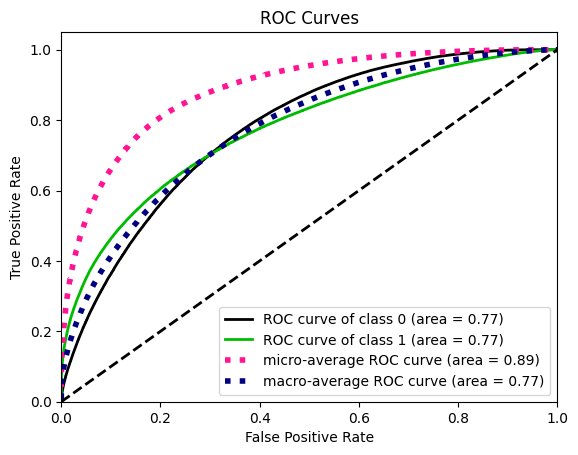

In [25]:
skplt.metrics.plot_roc_curve(y_test_clf, xgbc.predict_proba(xgbc_test))
plt.show()

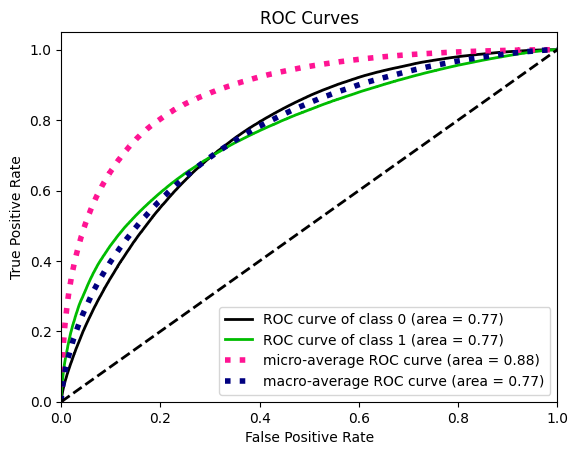

In [26]:
skplt.metrics.plot_roc_curve(y_test_clf, cbc.predict_proba(x_test))
plt.show()

In [27]:
shap.initjs()
explainer = shap.TreeExplainer(cbc)
shap_values = explainer.shap_values(eval_pool_clf)

In [28]:
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

In [29]:
shap.force_plot(explainer.expected_value, shap_values[0:100,:], x_train.iloc[0:100,:])

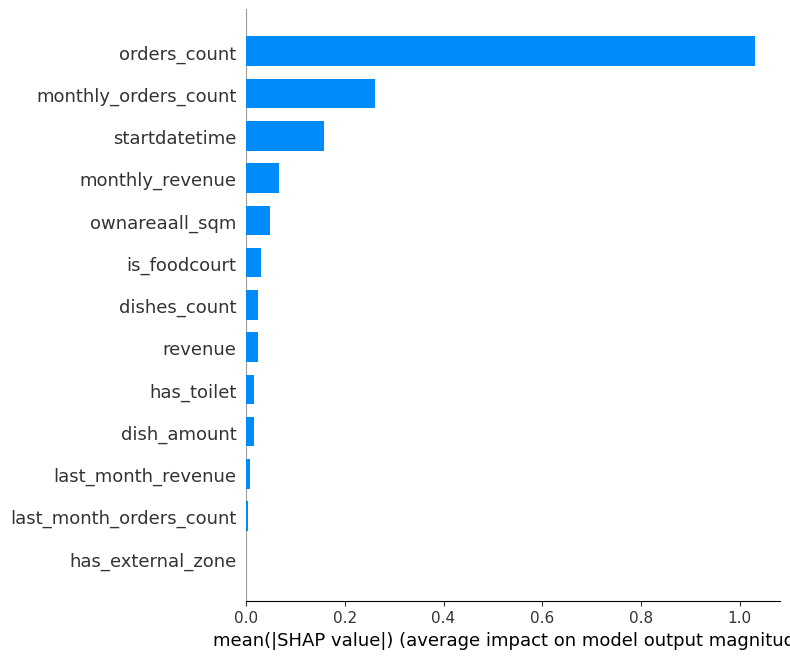

In [30]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

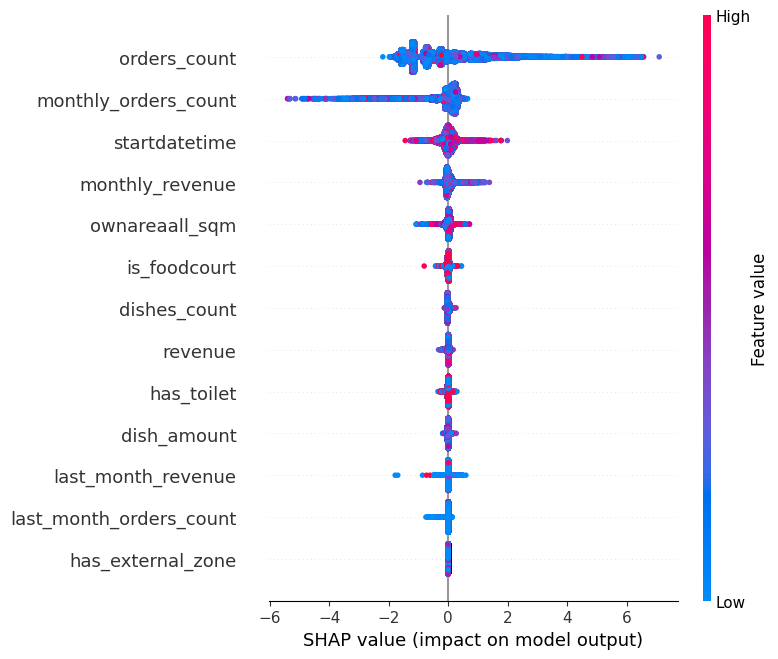

In [31]:
shap.summary_plot(shap_values[:100000], x_train[:100000])

# Train model on the full data

In [32]:
#cbc.load_model('/kaggle/working/cbc')
#cbr.load_model('/kaggle/working/cbc')
#xgbc.load_model('/kaggle/working/xgbc.json')

In [33]:
cbc = CatBoostClassifier(iterations=200, learning_rate=0.4, depth=8, l2_leaf_reg=10, loss_function='Logloss')
cbc.fit(full_train_clf, eval_set=eval_pool_clf)

0:	learn: 0.5197864	test: 0.5199367	best: 0.5199367 (0)	total: 1.47s	remaining: 4m 52s
1:	learn: 0.4681106	test: 0.4682899	best: 0.4682899 (1)	total: 2.92s	remaining: 4m 48s
2:	learn: 0.4525424	test: 0.4527478	best: 0.4527478 (2)	total: 4.18s	remaining: 4m 34s
3:	learn: 0.4449049	test: 0.4451000	best: 0.4451000 (3)	total: 5.43s	remaining: 4m 26s
4:	learn: 0.4410156	test: 0.4411812	best: 0.4411812 (4)	total: 6.74s	remaining: 4m 22s
5:	learn: 0.4400055	test: 0.4401727	best: 0.4401727 (5)	total: 7.94s	remaining: 4m 16s
6:	learn: 0.4387032	test: 0.4388232	best: 0.4388232 (6)	total: 9.27s	remaining: 4m 15s
7:	learn: 0.4379633	test: 0.4380838	best: 0.4380838 (7)	total: 10.6s	remaining: 4m 15s
8:	learn: 0.4375348	test: 0.4376322	best: 0.4376322 (8)	total: 11.9s	remaining: 4m 12s
9:	learn: 0.4369016	test: 0.4370082	best: 0.4370082 (9)	total: 13.1s	remaining: 4m 9s
10:	learn: 0.4362065	test: 0.4362919	best: 0.4362919 (10)	total: 14.3s	remaining: 4m 6s
11:	learn: 0.4359143	test: 0.4360073	best: 

In [34]:
cbr = CatBoostRegressor(iterations=200, learning_rate=0.4, depth=8, l2_leaf_reg=10)
cbr.fit(full_train_reg, eval_set=eval_pool_reg)

0:	learn: 15.8236563	test: 15.8179763	best: 15.8179763 (0)	total: 896ms	remaining: 2m 58s
1:	learn: 15.7143384	test: 15.7095344	best: 15.7095344 (1)	total: 1.94s	remaining: 3m 11s
2:	learn: 15.6753781	test: 15.6709385	best: 15.6709385 (2)	total: 2.89s	remaining: 3m 9s
3:	learn: 15.6563518	test: 15.6522558	best: 15.6522558 (3)	total: 3.84s	remaining: 3m 8s
4:	learn: 15.6414415	test: 15.6376953	best: 15.6376953 (4)	total: 4.91s	remaining: 3m 11s
5:	learn: 15.6336789	test: 15.6300328	best: 15.6300328 (5)	total: 5.93s	remaining: 3m 11s
6:	learn: 15.6284012	test: 15.6246021	best: 15.6246021 (6)	total: 6.78s	remaining: 3m 7s
7:	learn: 15.6240329	test: 15.6205508	best: 15.6205508 (7)	total: 7.84s	remaining: 3m 8s
8:	learn: 15.6205061	test: 15.6171175	best: 15.6171175 (8)	total: 8.69s	remaining: 3m 4s
9:	learn: 15.6172539	test: 15.6140107	best: 15.6140107 (9)	total: 9.55s	remaining: 3m 1s
10:	learn: 15.6139003	test: 15.6105260	best: 15.6105260 (10)	total: 10.5s	remaining: 3m 1s
11:	learn: 15.6

In [35]:
xgbc_x = x
xgbc_x['cbc_0'] = [n[0] for n in cbc.predict_proba(x)]
xgbc_x['cbc_1'] = [n[1] for n in cbc.predict_proba(x)]
xgbc_x['cbr'] = cbr.predict(x)
xgbc_x.sample(5)

,startdatetime,has_toilet,has_external_zone,is_foodcourt,revenue,ownareaall_sqm,dish_amount,dishes_count,orders_count,monthly_orders_count,monthly_revenue,last_month_orders_count,last_month_revenue,cbc_0,cbc_1,cbr
365291,1.667340e+09,True,0,False,619.97,277,6,6,15,9,5367.37,0,0.00,0.049571,0.950429,10.069874
1833883,1.683221e+09,True,2,False,174.98,244,2,2,4,3,599.91,0,0.00,0.276781,0.723219,19.357845
798513,1.672159e+09,False,0,True,249.96,102,5,5,4,3,774.87,3,774.87,0.203904,0.796096,19.941076
1440621,1.679091e+09,True,2,False,229.99,380,3,3,39,22,4312.71,0,0.00,0.003838,0.996162,5.392480
1665194,1.681432e+09,True,0,False,194.99,296,1,1,2,2,584.98,0,0.00,0.431693,0.568307,16.963651


In [36]:
xgbc = XGBClassifier()
xgbc.fit(xgbc_x, y_clf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [37]:
cbc.save_model('cbc')
cbr.save_model('cbr')
xgbc.save_model('xgbc.json')

# Predicting results

In [38]:
test_data = pd.read_parquet('/kaggle/input/burger-king-churn/hackaton2023_test.gzip')
test_data.sample(5)

,customer_id,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
2903541,23558461,test,10.00,2022-12-09 12:07:16,Влажная салфетка,102.0,Фудкорт без туалета
4792338,43351726,test,239.99,2023-04-20 17:16:01,Гранд Чиз Фреш,322.6,Отдельно стоящий с внешней зоной
4372239,35399859,test,119.99,2023-02-10 17:12:22,Up Кинг Фри бол,978.7,Отдельно стоящий с внешней зоной
4028599,30252453,test,49.99,2023-02-16 11:20:20,Соус Сырный,262.0,Отдельно стоящий без внешней зоны
3971922,29810834,test,74.99,2022-10-14 17:17:53,Чикенбургер новый,188.7,Фудкорт без туалета


In [39]:
unique = test_data.customer_id.unique()
print(len(unique))
test_data = preprocess(test_data, is_train=False)
print(len(test_data['customer_id'].unique()))
test_data.head()

112334
112334


,bill_id,customer_id,dish_name,startdatetime,has_toilet,has_external_zone,is_foodcourt,revenue,ownareaall_sqm,dish_amount,dishes_count,orders_count,monthly_orders_count,monthly_revenue,last_month_orders_count,last_month_revenue
0,0,28039329,"[934, 788, 789]",1.662077e+09,False,0,True,1179.96,170,3,3,4,4,3449.86,0,0.0
1,1,33602398,"[599, 81, 611, 282, 803, 860, 561, 860, 544, 8...",1.662078e+09,True,2,False,619.95,307,13,13,3,3,801.93,0,0.0
2,2,28039329,[934],1.662078e+09,False,0,True,289.99,170,1,1,4,4,3449.86,0,0.0
3,3,29250460,"[846, 605, 666, 666, 605, 471, 183, 471, 289, ...",1.662079e+09,True,2,False,828.93,300,13,13,6,5,2609.78,0,0.0
4,4,19197657,[916],1.662080e+09,True,1,False,69.99,338,1,1,3,3,629.95,0,0.0


In [40]:
out = pd.DataFrame()
out['customer_id'] = test_data['customer_id']
test_x = test_data[[column for column in data.columns if column not in ['buy_post', 'date_diff_post', 'customer_id', 'dish_name', 'bill_id']]]

out['date_diff_post'] = cbr.predict(test_x)
xgbc_test = test_x
xgbc_test['cbc_0'] = [n[0] for n in cbc.predict_proba(test_x)]
xgbc_test['cbc_1'] = [n[1] for n in cbc.predict_proba(test_x)]
xgbc_test['cbr'] = cbr.predict(test_x)
out['buy_post'] = xgbc.predict(xgbc_test)

print(out.dtypes)
out.head()

customer_id         int64
date_diff_post    float64
buy_post            int64
dtype: object


,customer_id,date_diff_post,buy_post
0,28039329,8.514705,0
1,33602398,11.494142,0
2,28039329,10.158365,0
3,29250460,19.207344,1
4,19197657,10.321226,0


In [41]:
#aggregate predictions for paychecks to formulate a prediction for a single user
out = out.groupby('customer_id', as_index=False).mean().round(0)
out['date_diff_post'] = out['date_diff_post'].astype(int)
out['buy_post'] = out['buy_post'].astype(int)

for n, val in enumerate(out['buy_post']):
    if val == 0:
        out['date_diff_post'][n] = None
        
print(len(out.customer_id.unique()))
print(out.dtypes)
out.head()

112334
customer_id         int64
date_diff_post    float64
buy_post            int64
dtype: object


,customer_id,date_diff_post,buy_post
0,52341,21.0,1
1,69175,13.0,1
2,73427,4.0,1
3,134577,NaN,0
4,156357,19.0,1


In [42]:
out.to_csv('/kaggle/working/solution.csv', sep=';')